In [1]:
import ma_codes as codes
from ma_codes import mysize, mymap, gray_red

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import matplotlib.pyplot as plt
import scanpy as sc
import pandas as pd
import seaborn as sb

## Some Plotting Parameters
plt.rcParams["figure.figsize"] = (6, 5)
plt.rcParams.update({'font.size': 14})
plt.rcParams['pdf.fonttype'] = 42
sb.set_style("ticks")
rocket = sb.color_palette("rocket", as_cmap = True)

#pd.set_option("display.max_columns", 100)

#import diffxpy.api as de
#print(de.__version__)  ## before: v0.7.4

import diffxpy.api as de
print(de.__version__)  ## before: v0.7.4
sc.logging.print_version_and_date()

2024-08-08 20:11:21.569897: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-08 20:11:21.574917: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-08 20:11:21.587793: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1723140681.609363  478720 cuda_dnn.cc:8430] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1723140681.615863  478720 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-08 20:11:21.632803: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

v0.7.4
Running Scanpy 1.10.2, on 2024-08-08 20:11.


In [2]:
import sparse
sparse.__version__

'0.9.1'

In [3]:
object_folder = "/media/HDD_1/Janine/Aging_SingleCell/data_objects/"
adata = sc.read(object_folder + "230711_BleoAging_Lymphocytes_final.h5ad") 

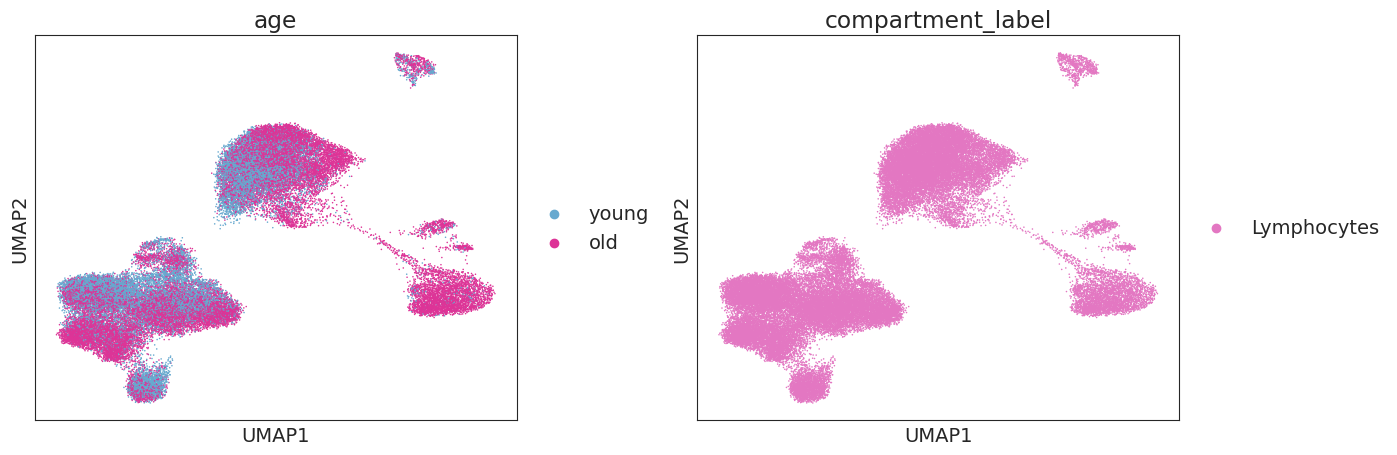

In [4]:
sc.pl.umap(adata, color = ["age", "compartment_label"], size = 5, wspace = 0.25)

In [5]:
adata

AnnData object with n_obs × n_vars = 47689 × 14953
    obs: 'age', 'barcode', 'batch', 'day', 'name', 'sex', 'treatment', 'identifier', 'n_counts', 'n_genes', 'percent_mito', 'doublet_scores', 'size_factors', 'S_score', 'G2M_score', 'phase', 'time_point', 'leiden_1', 'leiden_2', 'domain', 'cell_type', 'ct_level2', 'compartment_label', 'meta_label', 'age_treatment', 'age_day'
    var: 'n_cells', 'means', 'dispersions', 'dispersions_norm', 'n_counts', 'highly_variable', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'age_colors', 'age_day_colors', 'age_treatment_colors', 'batch_colors', 'cell_type_colors', 'compartment_label_colors', 'ct_level2_colors', 'day_colors', 'dendrogram_cell_type', 'domain_colors', 'hvg', 'leiden', 'leiden_1_colors', 'leiden_2_colors', 'meta_label_colors', 'neighbors', 'pca', 'sex_colors', 'time_point_colors', 'treatment_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts', 'unsouped_counts'
    obsp: 'connectivit

In [6]:
### Scaling of counts is recommended for diffxpy
adata.obs["n_counts_scaled"] = adata.obs["n_counts"] / adata.obs["n_counts"].mean()

### Subset to only old T cells

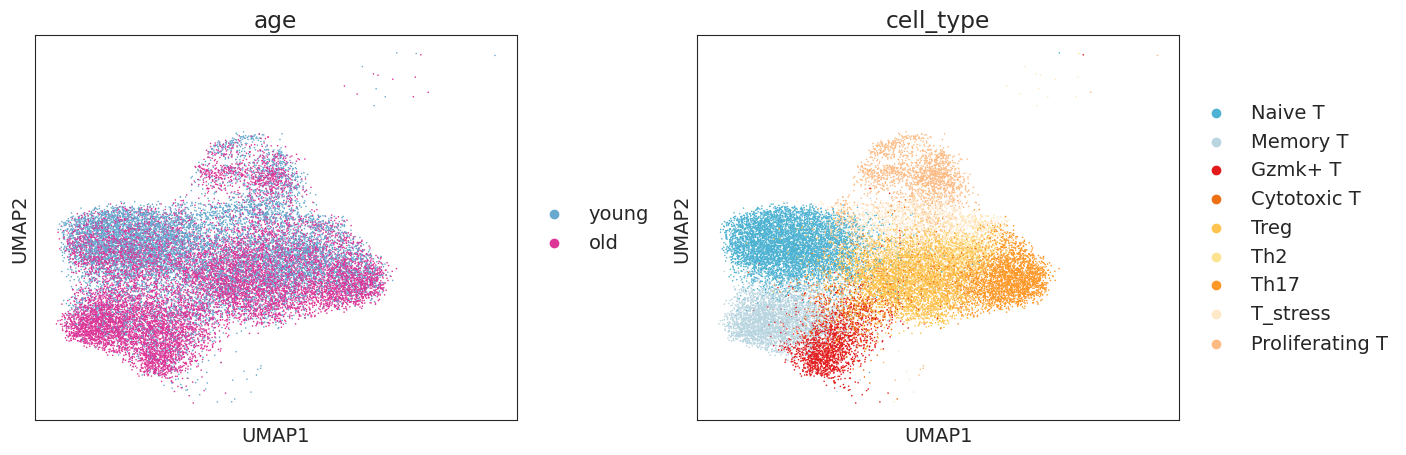

In [7]:
adata = adata[adata.obs["meta_label"].isin(["T cells"])].copy()
#B = adata[adata.obs["meta_label"].isin(["B cells", "Plasma cells"])].copy()
sc.pl.umap(adata, color = ["age", "cell_type"], wspace = 0.25)

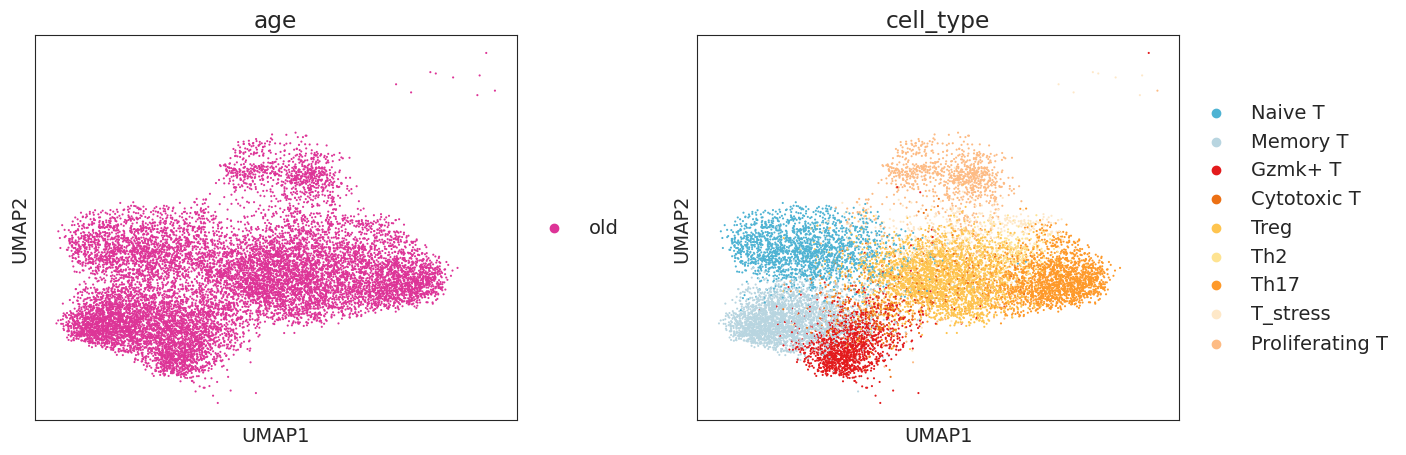

In [8]:
adata = adata[adata.obs["age"].isin(["old"])].copy()
sc.pl.umap(adata, color = ["age", "cell_type"], wspace = 0.25)

In [9]:
list(adata.obs.cell_type.unique())

['Proliferating T',
 'Memory T',
 'Naive T',
 'Cytotoxic T',
 'Th17',
 'Treg',
 'T_stress',
 'Gzmk+ T',
 'Th2']

### Write it into function finally

In [10]:
def dge(a, ct = "Gzmk+ T", ct_label = "cell_type", condition = "treatment", ref = "control", 
        pct_thresh = 0.05, subset = ["control", "bleo"], min_cells = 10, do_return = None, 
        suffix = "", myofib = None):
    
    if myofib:
        cells = a.obs.loc[:, ct_label].isin(subset)
    else:
        cells = a.obs.loc[:, ct_label] == ct
    
    count = a[cells].obs.loc[:, condition].value_counts()
    if (len(count) < 2) or (count[0] < min_cells) or (count[1] < min_cells):
        print("Too few cells in one condition (%s)\n%s" %(ct, count))
        return
        
    ## As threshold, take 5% of all cells in cell type per group
    tab = pd.DataFrame(index = a.var_names)
    tab = codes.add_pct(a[cells], tab = tab, group_by = condition,
                        gene_label = "index", ids = subset)
    test_genes = tab[(tab.loc[:, "pct.%s" %subset[0]] > pct_thresh) | (tab.loc[:, "pct.%s" %subset[1]] > pct_thresh)].index

    if myofib:
        print("Running Myofibroblast Version")
        adata_raw = codes.generate_count_object(a[:, test_genes], condition = condition,
                                                cell_type_label = ct_label, cell_type = subset, 
                                                ref = ref, min_cells = 5, subset = subset)
    
    else:
        adata_raw = codes.generate_count_object(a[:, test_genes], condition = condition, 
                                                cell_type_label = ct_label, cell_type = [ct], 
                                                ref = ref, min_cells = 5, subset = subset)

    print("Started Diffxpy Calculation:\t%s" %codes.timestamp())

    de_test = de.test.wald(data = adata_raw.X, formula_loc = "~ 1 + %s" %condition,
                           factor_loc_totest = condition,
                           training_strategy = [{"max_steps": 100, "update_b_freq": 5,
                                                "ftol_b": 1e-8, "max_iter_b": 100}],
                           gene_names = adata_raw.var_names, sample_description = adata_raw.obs,
                           noise_model = "nb", size_factors = "n_counts_scaled")

    print("Finished Diffxpy Calculation:\t%s" %codes.timestamp())

    ## Export Table
    res = codes.tidy_table(de_test, a, cells = adata_raw.obs_names, ids = subset,
                           group_by = condition, qval_thresh = 1.0)

    filename = "diffxpy_%s_vs_%s_%s.txt" %(subset[0], subset[1], ct.replace(" ", "_"))
    print("Saving to %s\n" %filename)
    res.to_csv("%s%s" %(out_folder, filename), sep = "\t", index = False)
    
    if do_return:
        return res
    

In [11]:
cell_types = ['Gzmk+ T']

In [12]:
pd.crosstab(adata.obs.cell_type, adata.obs.treatment)

treatment,control,bleo
cell_type,,
Naive T,605,1388
Memory T,678,1936
Gzmk+ T,491,913
Cytotoxic T,131,281
Treg,541,2265
Th2,74,257
Th17,565,1255
T_stress,139,388
Proliferating T,375,613


###  Control vs Bleo Gzmk+ T

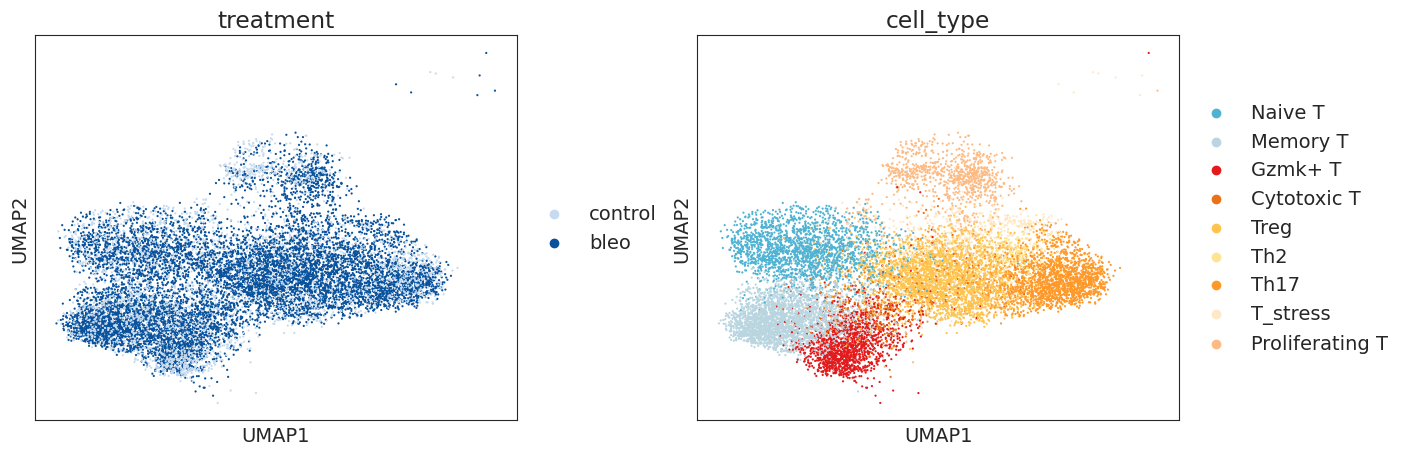

Gzmk+ T - treatment
(1404, 2909)


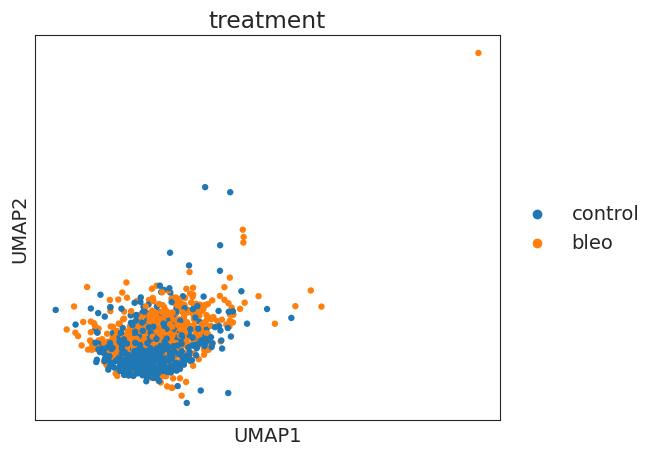

Started Diffxpy Calculation:	08-08-2024 20:11:26
training location model: True
training scale model: True
iter   0: ll=2106768.442818
iter   1: ll=1889261.627126, converged: 0.00% (loc: 0.00%, scale update: False), in 2.17sec
iter   2: ll=1848205.758710, converged: 0.00% (loc: 0.00%, scale update: False), in 1.30sec
iter   3: ll=1846496.713841, converged: 0.00% (loc: 0.00%, scale update: False), in 1.30sec
iter   4: ll=1846491.304739, converged: 0.00% (loc: 0.00%, scale update: False), in 1.22sec
iter   5: ll=1846491.300368, converged: 0.00% (loc: 16.71%, scale update: False), in 1.12sec
iter   6: ll=1829620.106144, converged: 0.00% (loc: 0.00%, scale update: True), in 10.26sec
iter   7: ll=1829569.846490, converged: 0.00% (loc: 0.00%, scale update: False), in 1.30sec
iter   8: ll=1829569.670106, converged: 0.00% (loc: 6.15%, scale update: False), in 1.24sec
iter   9: ll=1829569.669604, converged: 0.00% (loc: 70.51%, scale update: False), in 1.17sec
iter  10: ll=1829569.669602, converg

In [13]:
out_folder = "/home/gotej/Projects/Aging_BleoModel/Data/Dge_Gzmk_T_bleo_vs_control/"

subset = ["control", "bleo"]
condition = "treatment"
ct_label = "cell_type"
min_cells = 10

#time = "d0"
#time_subset = adata[adata.obs.day == time].copy()
sc.pl.umap(adata, color = ["treatment", "cell_type"], size = 10, wspace = 0.25)

for ct in cell_types:
    
    print("%s - %s" %(ct, "treatment"))
    dge(adata, ct = ct, ct_label = ct_label, condition = condition, ref = "control", pct_thresh = 0.05,
        subset = subset, min_cells = min_cells, do_return = False, suffix = "")

In [15]:
tab = pd.read_csv(out_folder + "diffxpy_control_vs_bleo_Gzmk+_T.txt", sep = "\t", index_col = 0)
tab.head()

,pval,qval,log2fc,pct.control,pct.bleo
gene,,,,,
Ccl5,4.440892e-16,1.291856e-12,-0.381047,0.987780,0.971522
S100a10,1.998401e-15,2.906675e-12,-0.556884,0.663951,0.469880
Malat1,3.774758e-15,3.660257e-12,-0.556791,0.887984,0.786418
Ms4a4b,1.265654e-14,9.204471e-12,-0.363670,0.879837,0.777656
Pim1,3.799627e-12,2.210623e-09,-0.993980,0.268839,0.106243


In [21]:
## Selecting genes significantly upregulated in Adipocyte population at day 4
tab = tab[tab.qval < 0.05].copy()
min_pct_thresh = 0.05

up_genes = tab[(tab.log2fc > 0.25) & (tab.loc[:, "pct.bleo"] > min_pct_thresh)].index.values
down_genes = tab[(tab.log2fc < -0.25) & (tab.loc[:, "pct.bleo"] > min_pct_thresh)].index.values
print(len(up_genes))
print(len(down_genes))

82
73


In [22]:
print(up_genes)

['mt-Co1' 'mt-Cytb' 'Ddx5' 'Ly6e' 'BC005537' 'Rps26' 'Zfas1' 'Ptpn22'
 'Dusp2' 'Rps27' 'Rnf213' 'Rplp0' 'Ctla2a' 'Isg20' '4932438A13Rik' 'Rps29'
 'Ltb' 'Itgb1' 'Cd8a' 'Shisa5' 'Rcbtb2' 'Kcnn4' 'Sorl1' 'Srsf10' 'Junb'
 'Gimap4' 'Cxcr3' 'Tcf7' 'Rsrp1' 'Uba52' 'Gimap3' 'Ip6k1' 'Aim2' 'Mxd4'
 'Rpl31' 'Gadd45b' 'Clk1' 'Zbp1' 'Zfp36' 'Sema4a' 'Ddit4' 'Dnajb1' 'Skil'
 'Ubb' 'Napa' 'Ncoa3' 'mt-Nd5' 'Rgs2' 'Adgrg5' 'Nufip2' 'Rps17' 'Coro1a'
 'Itgal' 'Znrf1' 'mt-Nd4' 'Dazap1' 'mt-Nd2' 'Lemd2' 'Psmc6' 'Kif1b' 'Xist'
 'Apobec3' 'Plgrkt' 'H2-Q4' 'AI504432' 'Gbp2' 'Stat1' 'Bptf' 'Sf1'
 'mt-Nd1' 'Bag6' 'Ubash3a' 'Ivns1abp' 'Cxcr4' 'Numa1' 'Nucb1' 'Socs1'
 'Lpxn' 'Gng2' 'Ssh2' 'Cyld' 'Vars']


In [23]:
print(down_genes)

['Ccl5' 'S100a10' 'Malat1' 'Ms4a4b' 'Pim1' 'S100a4' 'Prf1' 'Spn' 'Gm2682'
 'Tmsb4x' 'Klf3' 'Hsp90ab1' 'Atp2b1' 'Arl4c' 'Calm1' 'Atp1b3' 'Rpl30'
 'Cd2' 'Ms4a6b' 'Ubash3b' 'Txk' 'Add3' 'Ncl' 'Igf2r' 'Dnajc9' 'Lpin1'
 'Rasgrp2' 'Arap2' 'Tpr' 'Rasa3' 'Ripor2' 'Eea1' 'Crip1' 'Adam19'
 'Serpinb6b' 'Fam107b' 'Tmc6' 'Epsti1' 'Lsp1' 'Myl6' 'Eef1d' 'Ppp1r12a'
 'Rpl24' 'Trbc1' 'Dnajc1' 'S1pr4' 'Klf2' 'Rbm28' 'Bod1l' 'Nsa2' 'Naa15'
 'Gzmb' 'Abracl' 'Ak2' 'Pycard' 'Cd247' 'Smc4' 'Maf' 'Tmsb10' 'Cox5b'
 'Tpm3' 'Ndfip2' 'S100a6' 'Frg1' 'Zfp638' 'Sept11' 'Hspd1' 'Nap1l1'
 'Golgb1' 'Gm4759' 'Iqgap2' 'Supt16' 'Vsir']


In [24]:
adata = adata[adata.obs.cell_type == "Gzmk+ T"].copy()

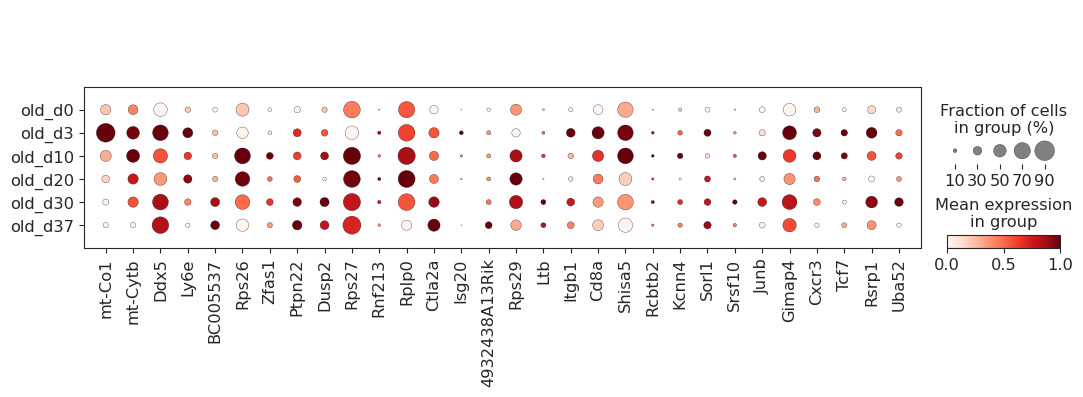

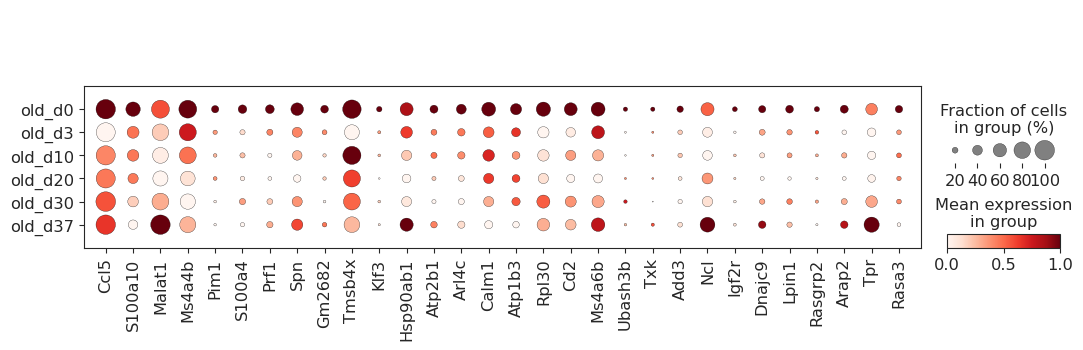

In [25]:
sc.pl.dotplot(adata, var_names = up_genes[:30], groupby = "age_day", standard_scale="var")
sc.pl.dotplot(adata, var_names = down_genes[:30], groupby = "age_day", standard_scale="var")